-- Contents --
1. Import modules and define functions
2. Prepare sample for model developments
3. Univariate analysis
4. Data cleaning and data manipulation
5. Train Sample - Information Value and Slope
6. Features pruning:
7. Replace Train and Test samples with WoE
8. Train WoE Logistic Regression
9. XGBoost training and AAC Assignment

Import modules and define functions

In [1]:
from Modules import *

def calculate_thresholds(n_records, n_bads, n_goods):
    # Total threshold
    if n_records <= 3000: tot_thresh = 0.1
    elif n_records > 3000 and n_records <= 5000: tot_thresh = 0.05
    elif n_records > 5000 and n_records <= 20000: tot_thresh = 0.03
    elif n_records > 20000 and n_records <= 50000: tot_thresh = 0.01
    else: tot_thresh = 0.005
    # Bad threshold
    if n_bads <= 3000: bad_thresh = 0.10
    elif n_bads > 3000 and n_bads <= 5000: bad_thresh = 0.05
    elif n_bads > 5000 and n_bads <= 20000: bad_thresh = 0.03
    elif n_bads > 20000 and n_bads <= 50000: bad_thresh = 0.01
    else:bad_thresh = 0.005
    # Good threshold
    if n_goods <= 3000: good_thresh = 0.10
    elif n_goods > 3000 and n_goods <= 5000: good_thresh = 0.05
    elif n_goods > 5000 and n_goods <= 20000: good_thresh = 0.03
    elif n_goods > 20000 and n_goods <= 50000: good_thresh = 0.01
    else: good_thresh = 0.005
    return tot_thresh, bad_thresh, good_thresh

def calculate_scorecard(d1, char):
    d2 = d1.groupby([char], dropna=False)
    d3 = pd.DataFrame(d2["X"].min(), columns=["min"])
    d3["# Good"] = d2["Y"].sum()
    d3["# Bad"] = d2["Y"].count() - d3["# Good"]
    d3["% Good"] = round(d3["# Good"] / d3["# Good"].sum() * 100, 1)
    d3["% Bad"] = round(d3["# Bad"] / d3["# Bad"].sum() * 100, 1)
    d3["# Total"] = d2["Y"].count()
    d3["% Total"] = round(d3["# Total"] / d3["# Total"].sum() * 100, 1)
    d3["Information Odds"] = round(d3["% Good"] / d3["% Bad"], 2)
    d3["Bad Rate"] = round(d3["# Bad"] / (d3["# Bad"] + d3["# Good"]) * 100, 2)
    d3["WoE"] = round(np.log(d3["% Good"] / d3["% Bad"]), 2)
    d3['iv'] = (d3["% Good"] - d3["% Bad"]) * d3["WoE"] / 100
    iv = (d3["% Good"] - d3["% Bad"]) * d3["WoE"] / 100
    d4 = d3.sort_index().drop(columns=["min"], axis=1)
    return d4, iv


def featureMonotonicBinning(Y, X, char, newMap, TriggerPlot):
    r = 0
    bad_flag = 0
    n = 20
    while np.abs(r) != 1 and bad_flag == 0:
        d1 = pd.DataFrame({"X": X, "Y": Y})
        d1["Value"], bins = pd.qcut(d1["X"], n, duplicates="drop", retbins=True, precision=3)
        if len(bins) == 2:
            bins = bins.tolist()
            bins.insert(0, float("-inf"))
            bins.append(float("+inf"))
            d1["Value"] = pd.cut(d1["X"], bins=bins, precision=3, include_lowest=True)
        d2 = d1.groupby("Value", as_index=True)
        r,p = stats.spearmanr(d2.mean().X, d2.mean().Y)
        d3, iv = calculate_scorecard(d1, "Value")
        
        d3.dropna(inplace=True)
        
        if len(d3) < 3:
            bad_flag = 1
        n = n-1
       
    pctThresh, badThresh, goodThresh = calculate_thresholds(d3["# Total"].sum(),d3["# Bad"].sum(),d3["# Good"].sum())
    condition = [(d3["% Total"] < pctThresh*100) | (d3["% Bad"] < badThresh*100) | (d3["% Good"] < goodThresh*100)]
    d3["Not Robust"] = np.select(condition, [1], 0)
    criteria = d3["Not Robust"].sum()
    d3 = d3.reset_index()
    while criteria > 0:
        i = d3[d3["Not Robust"] == 1].index[0]
        #if first row -> merge two first categories
        if i == 0:
            bins = np.delete(bins, 1)
        # if last row -> merge two last categories
        elif i == (len(d3) - 1):
            bins = np.delete(bins, len(d3)-1)
        else:
            # if number of samples greater in former -> merge with latter
            if (d3.at[i-1 , "# Total"] > d3.at[i+1 , "# Total"]):
                bins = np.delete(bins, i+1)
            # if number of samples greater in latter -> merge with former
            else:
                bins = np.delete(bins, i)        
        d1 = pd.DataFrame({"X": X, "Y": Y, "Value": pd.cut(X, bins, precision=3, include_lowest=True)})
        d3, iv = calculate_scorecard(d1, "Value")
        condition = [
            (d3["% Total"] < pctThresh*100) | 
            (d3["% Bad"] < badThresh*100) | 
            (d3["% Good"] < goodThresh*100) ]
        d3["Not Robust"] = np.select(condition, [1], 0)
        criteria = d3["Not Robust"].sum()
        d3 = d3.reset_index()
    d3 = d3.drop(columns=["Not Robust"])
    infValue = round(d3['iv'].sum(),3)
    d3.to_csv(char+".csv")
    #Calculate Slope
    dataset = d3.reset_index()
    X_Train = dataset[['index']].values
    Y_Train = dataset['WoE'].values

    arrayOfValues = np.array(dataset[['index']])
    if len(arrayOfValues) > 1:
        from sklearn import linear_model
        lr = linear_model.LinearRegression()
        lr.fit(X_Train.reshape(len(X_Train), 1), Y_Train)
        result = round(lr.coef_[0], 3)

        if TriggerPlot:
            # Create a bar plot 
            sns.set(rc={"figure.figsize": (6, 3)})
            sns.barplot(x='Value', y='WoE', data=d3).set_title(newMap[char]+" - IV :"+str(infValue),fontsize=10)
            
            plt.xticks(fontsize=10, rotation = 90) 
            plt.yticks(fontsize=10) 
            
            plt.show()

    else:
        result = np.nan
        print("No WoE Plot available")

    return d3, infValue, result
    
def replace_woe(series,cut,woe):
    list=[]
    i=0
    while i<len(series):
        valuek=series[i]
        j=len(cut)-2
        m=len(cut)-2
        while j>=0:
            if valuek>cut[j]:
                j=-1
            else:
                j -=1
                m -= 1
        list.append(woe[m])
        i += 1
    return list

def render_iv_table(data, col_width=3.0, row_height=0.625, font_size=14.5,
                     header_color='#33B3FF', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax.get_figure(), ax

fieldsLabel = {
        'msisdn':'Mobile number of user',
        'aon':'Age on cellular network in days',
        'daily_decr30':'Daily amount spent from main account, averaged over last 30 days (in Indonesian Rupiah)',
        'daily_decr90':'Daily amount spent from main account, averaged over last 50 days (in Indonesian Rupiah)',
        'rental30':'Average main account balance over last 30 days',
        'rental90':'Average main account balance over last 90 days',
        'last_rech_date_ma':'Number of days since last recharge of main account',
        'last_rech_date_da':'Number of days since last recharge of data account',
        'last_rech_amt_ma':'Amount of last recharge of main account (in Indonesian Rupiah)',
        'cnt_ma_rech30':'Number of times main account got recharged in last 30 days',
        'fr_ma_rech30':'Frequency of main account recharged in last 30 days',
        'sumamnt_ma_rech30':'Total amount of recharge in main account over last 30 days (in Indonesian Rupiah)',
        'medianamnt_ma_rech30':'Median of amount of recharges done in main account over last 30 days at user level (in Indonesian Rupiah)',
        'medianmarechprebal30':'Median of main account balance just before recharge in last 30 days at user level (in Indonesian Rupiah)',
        'cnt_ma_rech90':'Number of times main account got recharged in last 90 days',
        'fr_ma_rech90':'Frequency of main account recharged in last 90 days',
        'sumamnt_ma_rech90':'Total amount of recharge in main account over last 90 days (in Indonesian Rupiah)',
        'medianamnt_ma_rech90':'Median of amount of recharges done in main account over last 90 days at user level (in Indonesian Rupiah)',
        'medianmarechprebal90':'Median of main account balance just before recharge in last 90 days at user level (in Indonesian Rupiah)',
        'cnt_da_rech30':'Number of times data account got recharged in last 30 days',
        'fr_da_rech30':'Frequency of data account recharged in last 30 days',
        'cnt_da_rech90':'Number of times data account got recharged in last 90 days',
        'fr_da_rech90':'Frequency of data account recharged in last 90 days',
        'cnt_loans30':'Number of loans taken by user in last 30 days',
        'amnt_loans30':'Total amount of loans taken by user in last 30 days',
        'maxamnt_loans30':'maximum amount of loan taken by the user in last 30 days',
        'medianamnt_loans30':'Median of amounts of loan taken by the user in last 30 days',
        'cnt_loans90':'Number of loans taken by user in last 90 days',
        'amnt_loans90':'Total amount of loans taken by user in last 50 days',
        'maxamnt_loans90':'maximum amount of loan taken by the user in last 90 days',
        'medianamnt_loans90':'Median of amounts of loan taken by the user in last 50 days',
        'payback30':'Average payback time in days over last 30 days',
        'payback90':'Average payback time in days over last 90 days',
        'pcircle':'Telecom circle',
        'pdate':'Date',
        'label':'Target'
        }

munch is not present in the environment. See https://trading-ig.readthedocs.io/en/latest/faq.html#optional-dependencies
can't import config from config file


Prepare sample for model developments

In [13]:
#Read in data
df = pd.read_csv("sample_data_intw.csv")

#Describe data
display(df.head(2))
display(df.info(verbose=True))
display(df.describe())
display(df.shape)


,label,msisdn,aon,daily_decr30,daily_decr90,rental30,rental90,last_rech_date_ma,last_rech_date_da,last_rech_amt_ma,...,maxamnt_loans30,medianamnt_loans30,cnt_loans90,amnt_loans90,maxamnt_loans90,medianamnt_loans90,payback30,payback90,pcircle,pdate
0,0,21408I70789,272.0,3055.05,3065.15,220.13,260.13,2.0,0.0,1539,...,6.0,0.0,2.0,12,6,0.0,29.0,29.0,UPW,20-07-2016
1,1,76462I70374,712.0,12122.00,12124.75,3691.26,3691.26,20.0,0.0,5787,...,12.0,0.0,1.0,12,12,0.0,0.0,0.0,UPW,10-08-2016


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209593 entries, 0 to 209592
Data columns (total 36 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   label                 209593 non-null  int64  
 1   msisdn                209593 non-null  object 
 2   aon                   209593 non-null  float64
 3   daily_decr30          209593 non-null  float64
 4   daily_decr90          209593 non-null  float64
 5   rental30              209593 non-null  float64
 6   rental90              209593 non-null  float64
 7   last_rech_date_ma     209593 non-null  float64
 8   last_rech_date_da     209593 non-null  float64
 9   last_rech_amt_ma      209593 non-null  int64  
 10  cnt_ma_rech30         209593 non-null  int64  
 11  fr_ma_rech30          209593 non-null  float64
 12  sumamnt_ma_rech30     209593 non-null  float64
 13  medianamnt_ma_rech30  209593 non-null  float64
 14  medianmarechprebal30  209593 non-null  float64
 15  

None

,label,aon,daily_decr30,daily_decr90,rental30,rental90,last_rech_date_ma,last_rech_date_da,last_rech_amt_ma,cnt_ma_rech30,...,cnt_loans30,amnt_loans30,maxamnt_loans30,medianamnt_loans30,cnt_loans90,amnt_loans90,maxamnt_loans90,medianamnt_loans90,payback30,payback90
count,209593.000000,209593.000000,209593.000000,209593.000000,209593.000000,209593.000000,209593.00000,209593.000000,209593.000000,209593.000000,...,209593.000000,209593.000000,209593.000000,209593.000000,209593.000000,209593.000000,209593.000000,209593.000000,209593.000000,209593.000000
mean,0.875177,8112.343445,5381.402289,6082.515068,2692.581910,3483.406534,3755.84780,3712.202921,2064.452797,3.978057,...,2.758981,17.952021,274.658747,0.054029,18.520919,23.645398,6.703134,0.046077,3.398826,4.321485
std,0.330519,75696.082531,9220.623400,10918.812767,4308.586781,5770.461279,53905.89223,53374.833430,2370.786034,4.256090,...,2.554502,17.379741,4245.264648,0.218039,224.797423,26.469861,2.103864,0.200692,8.813729,10.308108
min,0.000000,-48.000000,-93.012667,-93.012667,-23737.140000,-24720.580000,-29.00000,-29.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,246.000000,42.440000,42.692000,280.420000,300.260000,1.00000,0.000000,770.000000,1.000000,...,1.000000,6.000000,6.000000,0.000000,1.000000,6.000000,6.000000,0.000000,0.000000,0.000000
50%,1.000000,527.000000,1469.175667,1500.000000,1083.570000,1334.000000,3.00000,0.000000,1539.000000,3.000000,...,2.000000,12.000000,6.000000,0.000000,2.000000,12.000000,6.000000,0.000000,0.000000,1.666667
75%,1.000000,982.000000,7244.000000,7802.790000,3356.940000,4201.790000,7.00000,0.000000,2309.000000,5.000000,...,4.000000,24.000000,6.000000,0.000000,5.000000,30.000000,6.000000,0.000000,3.750000,4.500000
max,1.000000,999860.755200,265926.000000,320630.000000,198926.110000,200148.110000,998650.37770,999171.809400,55000.000000,203.000000,...,50.000000,306.000000,99864.560860,3.000000,4997.517944,438.000000,12.000000,3.000000,171.500000,171.500000


(209593, 36)

Univariate analysis

In [14]:
df = pd.read_csv("sample_data_intw.csv")#, index_col=0
weigth = 1 

print("Dataset shape")
display(df.shape)
# Check for exact duplicates
print("Checking for exact duplicates")
print(df.duplicated(keep=False).sum(),"exact duplicates")
print("")
print("Remove exact duplicates")
df = df.drop_duplicates()
print("New dataset shape")
display(df.shape)
print("")
# Univariate Analysis
print("Univariate Analysis")
chars = df.columns

# count the number of object columns and numeric columns
iCountObject = 0
iCountNumeric = 0

for k in range(len(chars)):
    if(df[chars[k]].dtype == 'object'):
        iCountObject += 1
    else:
        iCountNumeric += 1

print("Total number of variables: ",str(len(chars)))
print("Number of object variables: ",str(iCountObject))
print("Number of numeric variables: ",str(iCountNumeric))

#Create Univariates Table
d = pd.DataFrame(index = [0],columns=['Feature','Feature Type','# Records',"# Zero's","% Zero's","# Missing","% Missing","Minimum", "Mean", "Median", "Maximum", "Skewness","Kurtosis"])
d.to_csv('univariateAnalysis.csv')  
notApplicable = "N/A"
for z in range(len(chars)):
    # print(chars[z]+' - '+str(df[chars[z]].dtype))
    a = pd.read_csv('univariateAnalysis.csv',index_col=0)  
    if(df[chars[z]].dtype !='object'):
        dd = pd.DataFrame({'Feature':[chars[z]],
                            'Feature Type':df[chars[z]].dtype,
                            "# Records":len(df)*weigth,
                            "# Zero's": ((df[chars[z]] == 0).sum())*weigth,
                            "% Zero's" : round((df[chars[z]] == 0).sum()/len(df)*100,2),
                            "# Missing" : (df[chars[z]].isna().sum())*weigth,
                            "% Missing" : round((df[chars[z]].isna()).sum()/len(df)*100,2),
                            "Minimum" : round(df[chars[z]].min(),2),
                            "Mean" : round(df[chars[z]].mean(),2),
                            "Median" : round(df[chars[z]].median(),2),
                            "Maximum" : round(df[chars[z]].max(),2),
                            "Skewness" : round(df[chars[z]].skew(),2), #Positive Skewness -> LEFT SKEW -> -> Threshold is -0.5 < x < 0.5
                            "Kurtosis" : round(df[chars[z]].kurt(),2), #Negative Kurtosis -> FAT TAILS -> -> Threshold is 3
                             }
                            )
        s = pd.concat([a, dd])
        # s = s.dropna()
        s.to_csv('univariateAnalysis.csv')

    else:
        dd = pd.DataFrame({'Feature':[chars[z]],
                    'Feature Type':df[chars[z]].dtype,
                    "# Records": len(df)*weigth,
                    "# Zero's": ((df[chars[z]] == 0).sum())*weigth,
                    "% Zero's" : round((df[chars[z]] == 0).sum()/len(df)*100,1),
                    "# Missing" : (df[chars[z]].isna().sum())*weigth,
                    "% Missing" : round((df[chars[z]].isna()).sum()/len(df)*100,1),
                    "Minimum" : [notApplicable],
                    "Mean" : [notApplicable],
                    "Median" : [notApplicable],
                    "Maximum" : [notApplicable],
                    "Skewness" : [notApplicable],
                    "Kurtosis" : [notApplicable]
                    }
                    )

        s = pd.concat([a, dd])
        # s = s.dropna()
        
        s.to_csv('univariateAnalysis.csv')

s = s.iloc[1:]
s.reset_index(inplace=True)
s = s.drop(columns=['index'], axis=1)
s = s.fillna("N/A")
display(s)
s.to_csv('univariateAnalysis.csv')
print("Number of variables in Univariate Analysis: ",str(len(s)))
print("")

Dataset shape


(209593, 36)

Checking for exact duplicates
2 exact duplicates

Remove exact duplicates
New dataset shape


(209592, 36)


Univariate Analysis
Total number of variables:  36
Number of object variables:  3
Number of numeric variables:  33


,Feature,Feature Type,# Records,# Zero's,% Zero's,# Missing,% Missing,Minimum,Mean,Median,Maximum,Skewness,Kurtosis
0,label,int64,209592.0,26162.0,12.48,0.0,0.0,0.0,0.88,1.0,1.0,-2.27,3.15
1,msisdn,object,209592.0,0.0,0.00,0.0,0.0,N/A,N/A,N/A,N/A,N/A,N/A
2,aon,float64,209592.0,0.0,0.00,0.0,0.0,-48.0,8112.38,527.0,999860.76,10.39,109.26
3,daily_decr30,float64,209592.0,4144.0,1.98,0.0,0.0,-93.01,5381.41,1469.09,265926.0,3.95,30.97
4,daily_decr90,float64,209592.0,4063.0,1.94,0.0,0.0,-93.01,6082.53,1500.0,320630.0,4.25,35.75
5,rental30,float64,209592.0,7566.0,3.61,0.0,0.0,-23737.14,2692.58,1083.54,198926.11,4.52,58.72
6,rental90,float64,209592.0,6918.0,3.30,0.0,0.0,-24720.58,3483.41,1334.0,200148.11,4.44,46.88
7,last_rech_date_ma,float64,209592.0,20743.0,9.90,0.0,0.0,-29.0,3755.87,3.0,998650.38,14.79,223.25
8,last_rech_date_da,float64,209592.0,202860.0,96.79,0.0,0.0,-29.0,3712.22,0.0,999171.81,14.81,224.27
9,last_rech_amt_ma,int64,209592.0,20995.0,10.02,0.0,0.0,0.0,2064.46,1539.0,55000.0,3.78,41.32


Number of variables in Univariate Analysis:  36



Data cleaning and data manipulation

In [15]:
df = pd.read_csv("sample_data_intw.csv")

df['day'] = df['pdate'].astype(str).str[0:2].astype(int) 
df['month'] = df['pdate'].astype(str).str[3:5].astype(int) 
df['year'] = df['pdate'].astype(str).str[6:10].astype(int) 
display(df['year'])
display(pd.crosstab(df['month'],df['label']))

#Drop August data
df = df[df['month'] < 8]
#Drop feautures: msisdn, pdate, pcircle, day, month, year
df = df.drop(columns=['msisdn','pcircle','pdate','day','month','year'], axis=1)
display(df.info(verbose=True))

#Create Train vs Train random samples (50% vs 50%)
train = df.sample(frac=0.5, replace=False)
test = df.drop(train.index)
print("Shape of Train and Test samples")
print(train.shape)
print(test.shape)
print("")

#Write out Train and Test samples which will be used for Model Development
train.to_csv("train.csv", index=False)
test.to_csv("test.csv", index=False)

#Write out Train and Test samples which will be used for WoE Analysis
train.to_csv("trainWoE.csv", index=False)
test.to_csv("testWoE.csv", index=False)
print("")


0         2016
1         2016
2         2016
3         2016
4         2016
          ... 
209588    2016
209589    2016
209590    2016
209591    2016
209592    2016
Name: year, Length: 209593, dtype: int32

label,0,1
month,,
6,13261,69893
7,12901,72864
8,0,40674


<class 'pandas.core.frame.DataFrame'>
Index: 168919 entries, 0 to 209592
Data columns (total 33 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   label                 168919 non-null  int64  
 1   aon                   168919 non-null  float64
 2   daily_decr30          168919 non-null  float64
 3   daily_decr90          168919 non-null  float64
 4   rental30              168919 non-null  float64
 5   rental90              168919 non-null  float64
 6   last_rech_date_ma     168919 non-null  float64
 7   last_rech_date_da     168919 non-null  float64
 8   last_rech_amt_ma      168919 non-null  int64  
 9   cnt_ma_rech30         168919 non-null  int64  
 10  fr_ma_rech30          168919 non-null  float64
 11  sumamnt_ma_rech30     168919 non-null  float64
 12  medianamnt_ma_rech30  168919 non-null  float64
 13  medianmarechprebal30  168919 non-null  float64
 14  cnt_ma_rech90         168919 non-null  int64  
 15  fr_ma

None

Shape of Train and Test samples
(84460, 33)
(84459, 33)




Train Sample - Information Value and Slope

In [16]:
train = pd.read_csv("train.csv")
# Information Value (I.V.)
colList = list(train.columns)
colList.pop(0)
target = 'label'

if True:
    d = pd.DataFrame(index = [0],columns=['Feature Name','Feature Label','Inf. Value',"Slope"])
    d.to_csv('informationValueTable.csv')  
    notApplicable = "N/A"

    for i in range(len(colList)):
        a = pd.read_csv('informationValueTable.csv',index_col=0)  
        print("Processing feature: "+fieldsLabel[colList[i]])
        d3, infValue, result = featureMonotonicBinning(train[target], train[colList[i]], colList[i],fieldsLabel, False)
        dd = pd.DataFrame({'Feature Name':[colList[i]],
                            'Feature Label':fieldsLabel[colList[i]],
                            "Inf. Value":infValue,
                            "Slope": result})

        s = pd.concat([a, dd])
        # s = s.dropna()
        s.to_csv('informationValueTable.csv')

s = s.iloc[1:]
s.reset_index(inplace=True)
s = s.drop(columns=['index'], axis=1).sort_values(by='Inf. Value',ascending=False).fillna("N/A").reset_index().drop(columns=['index'],axis=1)
display(s)
s.to_csv('informationValueTable.csv')

Processing feature: Age on cellular network in days
Processing feature: Daily amount spent from main account, averaged over last 30 days (in Indonesian Rupiah)
Processing feature: Daily amount spent from main account, averaged over last 50 days (in Indonesian Rupiah)
Processing feature: Average main account balance over last 30 days
Processing feature: Average main account balance over last 90 days
Processing feature: Number of days since last recharge of main account
Processing feature: Number of days since last recharge of data account
No WoE Plot available
Processing feature: Amount of last recharge of main account (in Indonesian Rupiah)
Processing feature: Number of times main account got recharged in last 30 days
Processing feature: Frequency of main account recharged in last 30 days
Processing feature: Total amount of recharge in main account over last 30 days (in Indonesian Rupiah)
Processing feature: Median of amount of recharges done in main account over last 30 days at user l

,Feature Name,Feature Label,Inf. Value,Slope
0,sumamnt_ma_rech90,Total amount of recharge in main account over ...,1.273,0.298
1,sumamnt_ma_rech30,Total amount of recharge in main account over ...,1.254,0.324
2,cnt_ma_rech90,Number of times main account got recharged in ...,1.249,0.558
3,cnt_ma_rech30,Number of times main account got recharged in ...,1.172,0.711
4,amnt_loans90,Total amount of loans taken by user in last 50...,0.925,0.82
5,amnt_loans30,Total amount of loans taken by user in last 30...,0.924,0.857
6,cnt_loans30,Number of loans taken by user in last 30 days,0.921,0.877
7,cnt_loans90,Number of loans taken by user in last 90 days,0.904,0.816
8,medianmarechprebal30,Median of main account balance just before rec...,0.516,0.81
9,medianamnt_ma_rech30,Median of amount of recharges done in main acc...,0.462,0.459


Features pruning:
 - drop features with IV = 0.00
 - drop amounts

In [17]:
ivList = pd.read_csv("informationValueTable.csv", index_col=0)
ivList = ivList[~ivList['Feature Label'].str.contains("amount|Amount|balance|amt")]
# display(ivList)
chars = list(ivList[ivList['Inf. Value'] > 0.00]['Feature Name'])
pprint(chars) 

['cnt_ma_rech90',
 'cnt_ma_rech30',
 'cnt_loans30',
 'cnt_loans90',
 'payback90',
 'fr_ma_rech30',
 'payback30',
 'fr_ma_rech90',
 'aon']


Replace Train and Test samples with WoE

In [18]:
train.to_csv("trainWoE.csv", index=False)
test.to_csv("testWoE.csv", index=False)

ninf = float('-inf')
pinf = float('+inf')

candidateChars = chars
binners = []
#Replace Features Values with WoE for Train Sample
for i in range(len(candidateChars)):
    print("Replacing WoE for feature: ",candidateChars[i]," - Train Sample")
    df = pd.read_csv(candidateChars[i]+'.csv', index_col=0)
    cutList = list([float(interval.split(', ')[1].rstrip(']')) for interval in list(np.array(df['Value']))])
    n = (len(cutList)-1)
    cutList.pop(n)
    cutList.append(pinf)
    cutList.insert(0,ninf)
    binners.append(cutList)
    woeList = list(np.array(df['WoE']))
    data = pd.read_csv("trainWoE.csv")
    data[candidateChars[i]] = replace_woe(data[candidateChars[i]], cutList, woeList)
    data.to_csv("trainWoE.csv",index=False)
data.to_csv("trainForDevelopment.csv", index=False)


#Replace Features Values with WoE for Test Sample
for i in range(len(candidateChars)):
    print("Replacing WoE for feature: ",candidateChars[i]," - Test Sample")
    df = pd.read_csv(candidateChars[i]+'.csv', index_col=0)
    cutList = list([float(interval.split(', ')[1].rstrip(']')) for interval in list(np.array(df['Value']))])
    n = (len(cutList)-1)
    cutList.pop(n)
    cutList.append(pinf)
    cutList.insert(0,ninf)

    woeList = list(np.array(df['WoE']))
    data = pd.read_csv("testWoE.csv")
    data[candidateChars[i]] = replace_woe(data[candidateChars[i]], cutList, woeList)
    data.to_csv("testWoE.csv",index=False)
data.to_csv("testForDevelopment.csv", index=False)


Replacing WoE for feature:  cnt_ma_rech90  - Train Sample
Replacing WoE for feature:  cnt_ma_rech30  - Train Sample
Replacing WoE for feature:  cnt_loans30  - Train Sample
Replacing WoE for feature:  cnt_loans90  - Train Sample
Replacing WoE for feature:  payback90  - Train Sample
Replacing WoE for feature:  fr_ma_rech30  - Train Sample
Replacing WoE for feature:  payback30  - Train Sample
Replacing WoE for feature:  fr_ma_rech90  - Train Sample
Replacing WoE for feature:  aon  - Train Sample
Replacing WoE for feature:  cnt_ma_rech90  - Test Sample
Replacing WoE for feature:  cnt_ma_rech30  - Test Sample
Replacing WoE for feature:  cnt_loans30  - Test Sample
Replacing WoE for feature:  cnt_loans90  - Test Sample
Replacing WoE for feature:  payback90  - Test Sample
Replacing WoE for feature:  fr_ma_rech30  - Test Sample
Replacing WoE for feature:  payback30  - Test Sample
Replacing WoE for feature:  fr_ma_rech90  - Test Sample
Replacing WoE for feature:  aon  - Test Sample


Train WoE Logistic Regression

Optimization terminated successfully.
         Current function value: 0.350446
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:                84460
Model:                          Logit   Df Residuals:                    84455
Method:                           MLE   Df Model:                            4
Date:                Fri, 24 Oct 2025   Pseudo R-squ.:                  0.1913
Time:                        13:03:23   Log-Likelihood:                -29599.
converged:                       True   LL-Null:                       -36598.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.6986      0.011    148.403      0.000       1.676       1.721
cnt_ma_rech90     0.

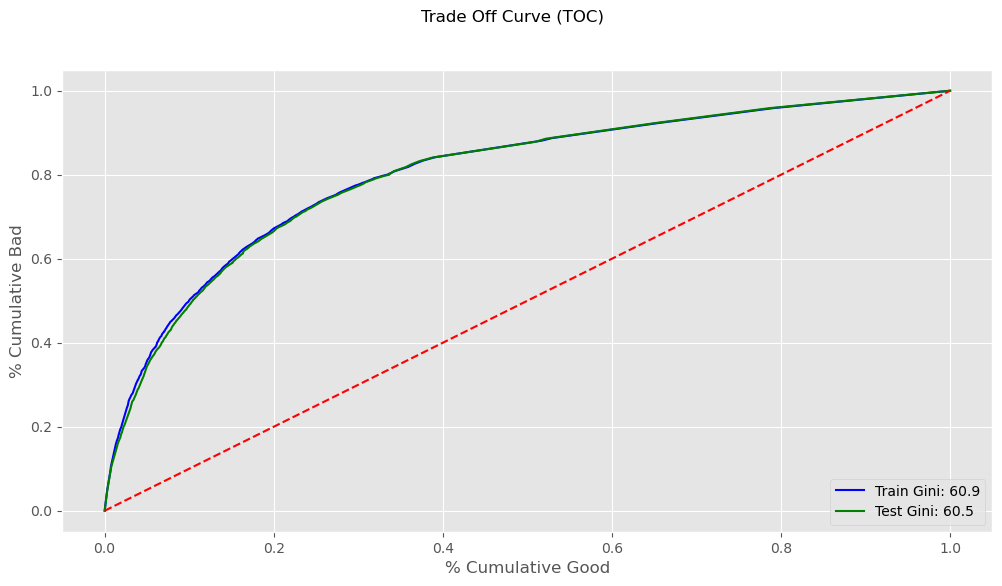

,Characteristics,Feature Label,MIV
0,cnt_loans90,Number of loans taken by user in last 90 days,33.95
1,payback90,Average payback time in days over last 90 days,0.00
2,fr_ma_rech30,Frequency of main account recharged in last 30...,0.00
3,payback30,Average payback time in days over last 30 days,0.00
4,fr_ma_rech90,Frequency of main account recharged in last 90...,0.00


In [19]:
#List of In-Model Features
col_list = [
            'cnt_ma_rech90',
            'cnt_ma_rech30',
            'cnt_loans30',
            # 'cnt_loans90',
            # 'payback90',
            # 'fr_ma_rech30',
            # 'payback30',
            # 'fr_ma_rech90',
            'aon',
            # 'last_rech_date_ma'
         ]


# Train WoE Logistic Regression on Train Sample
trainSample = pd.read_csv("trainForDevelopment.csv")
Y=trainSample[target]
X=trainSample[col_list]
X1=sm.add_constant(X)
    
logit=sm.Logit(Y,X1)
result=logit.fit()
print(result.summary())

# Predictive Power measure: Gini

# Gini for Train Sample
resu=result.predict(X1)
trainSample['Probability'] = resu
print("Minimum Probability: ",str(trainSample['Probability'].min()))
print("Average Probability: ",str(trainSample['Probability'].mean()))
print("Maximum Probability: ",str(trainSample['Probability'].max()))
fpr,tpr,threshold=roc_curve(Y,resu)
rocauc=auc(fpr,tpr)*100
x = round((rocauc-50)*2,1)
print("                 ")
print("Train Gini:  ",x)



# Gini for Test Sample
testSample = pd.read_csv("testForDevelopment.csv")
Y=testSample[target]
X=testSample[col_list]
X1=sm.add_constant(X)
resu=result.predict(X1)
fpr1,tpr1,threshold1=roc_curve(Y,resu)
rocauc=auc(fpr1,tpr1)*100
x1 = round((rocauc-50)*2,1)

print("Test Gini:  ",x1)


#Plot Gini
fig = plt.figure()    
fig.suptitle('Trade Off Curve (TOC)')
ax1 = fig.add_subplot(1,1,1)
# plt.plot(fpr,tpr,'b',label='ROC - Train: %0.1f'% rocauc)
plt.plot(fpr,tpr,'b',label='Train Gini: %0.1f'% x)
# plt.plot(fpr1,tpr1,'g',label='ROC - Test: %0.1f'% rocauc)
plt.plot(fpr1,tpr1,'g',label='Test Gini: %0.1f'% x1)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlabel('% Cumulative Good')
plt.ylabel('% Cumulative Bad')
plt.show()


# MIV Analysis

d = pd.read_csv("train.csv")
d = d.reset_index()

df = d.merge(trainSample, left_index=True, right_index=True)
df = df.drop(columns=['index'], axis=1)
df.to_csv("Dataset_for_MIV.csv")


d = pd.DataFrame(index = [0],columns=['Characteristics','MIV'])
d.to_csv('ee.csv')  

d= pd.read_csv('Dataset_for_MIV.csv')
d = d.drop(columns=['Unnamed: 0'],axis=1)

for z in range(len(chars)):
    if(chars[z] not in col_list):
        d = pd.read_csv('Dataset_for_MIV.csv')
        d = d.drop(columns=['Unnamed: 0'],axis=1)
        if(d[chars[z]+'_x'].dtype !='object'):    
            df= pd.read_csv('Dataset_for_MIV.csv')
            df = df.drop(columns=['Unnamed: 0'],axis=1)
            
            df[chars[z]+'_bin'] = pd.cut(x=df[chars[z]+'_x'], bins=binners[z])
            col = ['Probability',chars[z]+'_bin']
            df = df[col]
            dfx3 = df.groupby(chars[z]+'_bin').mean()
            dfx3 = dfx3.reset_index()
            dfx3 = dfx3.drop(columns=[chars[z]+'_bin'],axis=1)
            d = pd.read_csv(chars[z]+'.csv')
            d = d[:-3]
            data = d.merge(dfx3, left_index=True, right_index=True)
            data = data.drop(columns=['Unnamed: 0'],axis=1)    
            eg = []
            
            words = np.array(data['# Total'])
            #print(words)
            d = []
            for string in words:
                #d.append(0)
                newString = str(string).replace(',','')
                
                d.append(newString)
                
            data['t'] =d
            #a = data['t'].astype(float)
            t = np.array(data['t'].astype(float))
            p = np.array(data['Probability'])
            for n in range(len(t)):
                eg.append(0)
                eg[n] = round(float(t[n])*p[n],1)
            data['exp_Goods'] = eg

            eb = []
            
            p = np.array(data['Probability'])
            for n in range(len(t)):
                eb.append(0)
                eb[n] = round(float(t[n])*(1-p[n]),1)
            data['exp_Bads'] = eb
            
            data = data.drop(columns=['t'],axis=1)
            data['exp_pct_Goods'] = round(data['exp_Goods']/data['exp_Goods'].sum()*100,1)
            data['exp_pct_Bads'] = round(data['exp_Bads']/data['exp_Bads'].sum()*100,1)
            data['exp_WoE'] = round(np.log(data['exp_pct_Goods']/data['exp_pct_Bads']),2)          
            data['DeltaScore'] = data['WoE'] - data['exp_WoE']

            data['MIV'] = data['DeltaScore']*data['% Good'] - data['DeltaScore']*data['% Bad']
            x = round(data['MIV'].sum(),2)
            data.to_csv(chars[z]+'delta.csv')
            #print(chars[z]+': '+str(x))
            a = pd.read_csv('ee.csv',index_col=0)
            dd = pd.DataFrame({'Characteristics':chars[z],'MIV':"%.3f" %round(x,2)}, index=[0])
            s = pd.concat([a, dd])
            s = s.dropna()
            
            s.to_csv('ee.csv')            
              
d = pd.read_csv('ee.csv')
d = d.sort_values(by=['MIV'], ascending=False)
d = d.drop(columns=['Unnamed: 0'],axis=1)
d['Feature Label'] = d['Characteristics'].map(fieldsLabel)
d=d[['Characteristics','Feature Label','MIV']]
display(d)

XGBoost training:
 - get constraints
 - optimize hyperparameters 
 - fit model with constraints
 - evaluate SHAP 


##############################################################################
#                 1. DEFINE MONOTONIC PATTERNS                                
##############################################################################
(1, 1, 1, 1, 1, 1, 1, 1, 1, -1)
##############################################################################
#              3. XGBOOST FIT - BEST HYPER PARAMS                             
##############################################################################


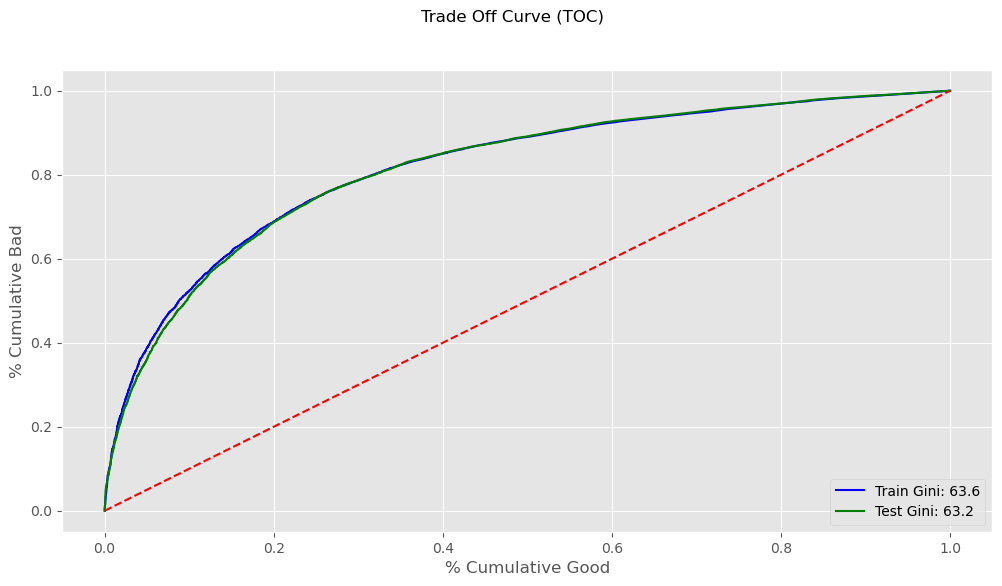

0.84369975
1.8559764630815716
Export Trees to plot


<Figure size 2000x1000 with 0 Axes>

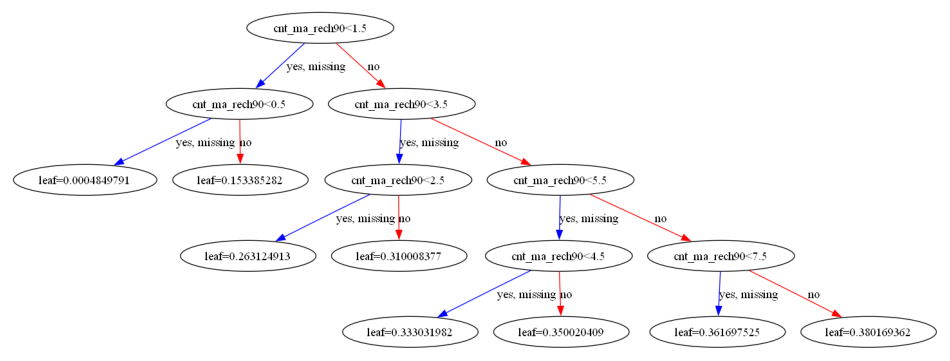


Features Importance

              feature  importance
0      cnt_ma_rech90       106.0
9  last_rech_date_ma        62.0
8                aon        46.0
1      cnt_ma_rech30        25.0
2        cnt_loans30        20.0
7       fr_ma_rech90        14.0
3        cnt_loans90         3.0
5       fr_ma_rech30         2.0
4          payback90         1.0
6          payback30         1.0

Calculate SHAP globally ....


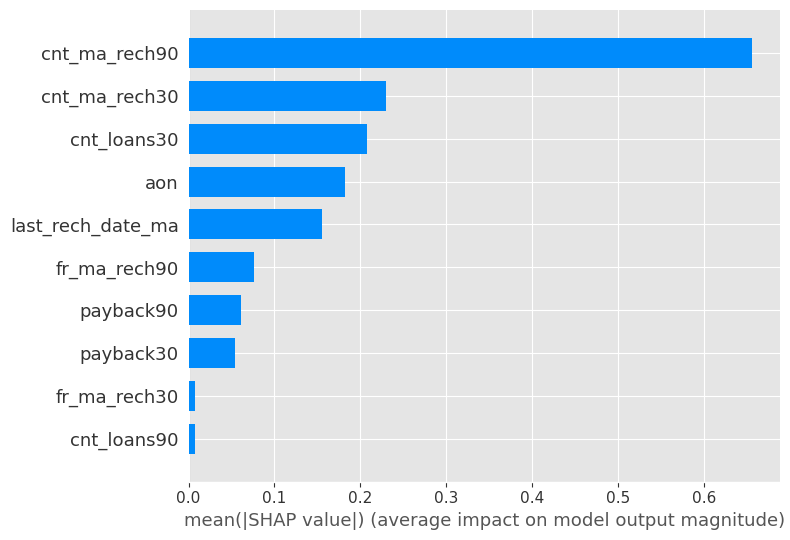

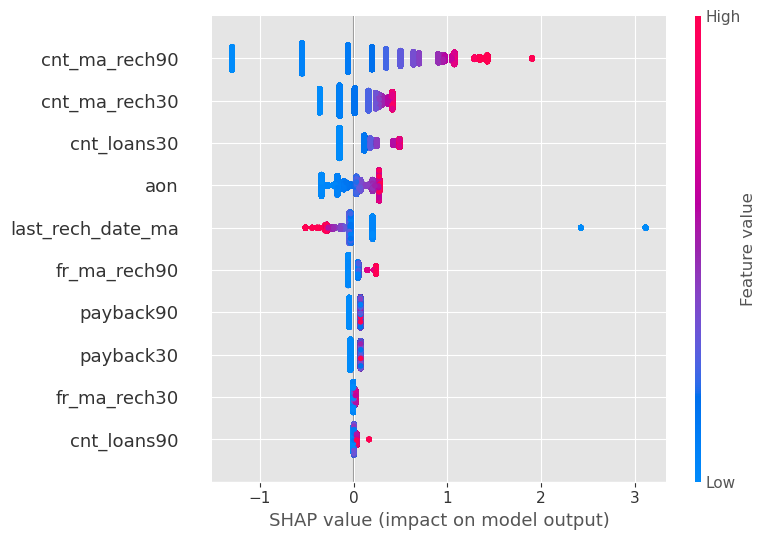

Calculate SHAP for each characteristic ....


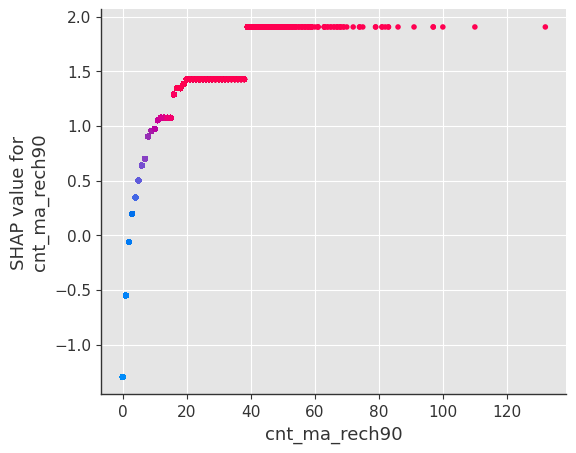

Base value 1.8044438
SHAP Values
[ 0.19506241  0.01149809 -0.15099452 -0.00295228 -0.04771271  0.01905894
 -0.03589637  0.05010001  0.28122476  0.20156796]

X.iloc[[j]]
   cnt_ma_rech90  cnt_ma_rech30  cnt_loans30  cnt_loans90  payback90  \
0              3              2            1          1.0        0.0   

   fr_ma_rech30  payback30  fr_ma_rech90     aon  last_rech_date_ma  
0          20.0        0.0            12  1925.0                1.0  



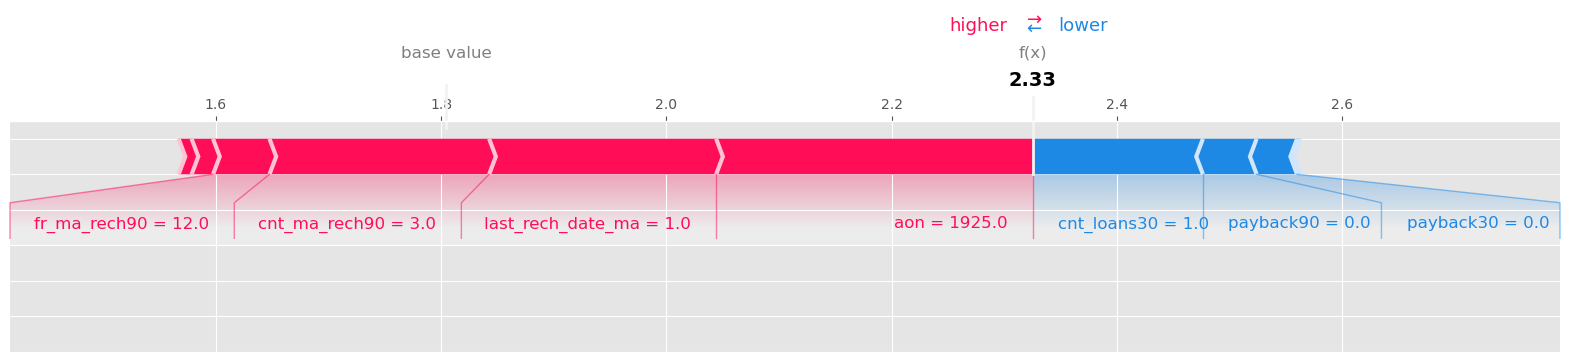

Expected Value:  1.8044438
Max New SHAP:  cnt_ma_rech90 3.7094106674194336
Max New SHAP:  cnt_ma_rech30 2.217092990875244
Max New SHAP:  cnt_loans30 2.293498992919922
Max New SHAP:  cnt_loans90 1.9689005613327026
Max New SHAP:  payback90 1.8774281740188599
Max New SHAP:  fr_ma_rech30 1.823502779006958
Max New SHAP:  payback30 1.8792223930358887
Max New SHAP:  fr_ma_rech90 2.044032573699951
Max New SHAP:  aon 2.0856685638427734
Max New SHAP:  last_rech_date_ma 4.91935920715332


,cnt_ma_rech90_shap1,cnt_ma_rech30_shap1,cnt_loans30_shap1,cnt_loans90_shap1,payback90_shap1,fr_ma_rech30_shap1,payback30_shap1,fr_ma_rech90_shap1,aon_shap1,last_rech_date_ma_shap1,...,fr_ma_rech30_shap,fr_ma_rech30_shapDiff,payback30_shap,payback30_shapDiff,fr_ma_rech90_shap,fr_ma_rech90_shapDiff,aon_shap,aon_shapDiff,last_rech_date_ma_shap,last_rech_date_ma_shapDiff
0,0.195062,0.011498,-0.150995,-0.002952,-0.047713,0.019059,-0.035896,0.050100,0.281225,0.201568,...,1.823503,0.000000,1.768547,0.110675,1.854544,0.189489,2.085669,0.000000,2.006012,2.913347
1,1.380986,0.412649,0.177987,0.030339,0.072984,0.002935,0.074779,0.045284,-0.023407,-0.032052,...,1.807379,0.016124,1.879222,0.000000,1.849727,0.194305,1.781037,0.304632,1.772392,3.146967
2,0.637615,0.236237,0.177987,0.002323,0.072984,0.019059,0.074779,0.050100,0.272064,0.201568,...,1.823503,0.000000,1.879222,0.000000,1.854544,0.189489,2.076508,0.009161,2.006012,2.913347
3,0.955333,0.368277,0.489055,0.030339,0.072984,0.002935,0.074779,0.045284,0.272064,-0.139905,...,1.807379,0.016124,1.879222,0.000000,1.849727,0.194305,2.076508,0.009161,1.664539,3.254820
4,0.195062,0.157811,0.177987,0.002323,0.072984,0.019059,0.074779,0.050100,0.072561,-0.032052,...,1.823503,0.000000,1.879222,0.000000,1.854544,0.189489,1.877004,0.208664,1.772392,3.146967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84455,-0.060768,0.011498,0.113095,0.002323,0.072984,0.019059,0.074779,0.147100,-0.079788,0.201568,...,1.823503,0.000000,1.879222,0.000000,1.951544,0.092489,1.724656,0.361012,2.006012,2.913347
84456,1.051788,0.412649,0.113095,0.002323,-0.047713,-0.004778,-0.035896,-0.059838,0.201820,-0.032052,...,1.799666,0.023837,1.768547,0.110675,1.744606,0.299427,2.006264,0.079404,1.772392,3.146967
84457,-0.550705,-0.149257,-0.150995,-0.002952,-0.047713,-0.004778,-0.035896,-0.059838,-0.105373,-0.139905,...,1.799666,0.023837,1.768547,0.110675,1.744606,0.299427,1.699070,0.386598,1.664539,3.254820
84458,-1.296057,-0.361522,-0.150995,-0.002952,-0.047713,-0.004778,-0.035896,-0.059838,-0.105373,0.201568,...,1.799666,0.023837,1.768547,0.110675,1.744606,0.299427,1.699070,0.386598,2.006012,2.913347


Adverse Code assignment: complete.

Merge input data with Adverse Codes


In [ ]:
#Read in train sample
import graphviz
graphviz.set_default_engine('dot')

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
import numpy as np

# List of candidate features
col_list = [
            'cnt_ma_rech90',
            'cnt_ma_rech30',
            'cnt_loans30',
            'cnt_loans90',
            'payback90',
            'fr_ma_rech30',
            'payback30',
            'fr_ma_rech90',
            'aon',
            'last_rech_date_ma'
         ]


target = 'label'
Y = train[target].values
X = train[col_list]

if True:    
    print("##############################################################################")
    print("#                 1. DEFINE MONOTONIC PATTERNS                                ")
    print("##############################################################################")    
    
    iv = pd.read_csv("informationValueTable.csv")
    iv = iv[iv['Feature Name'].isin(col_list)]
    iv['monConstr'] = np.where(iv['Slope']>0,1,-1)
    # constraintsMap = dict(zip(iv['Feature Name'],iv['monConstr']))
    mono_constraints = (np.array(iv['monConstr'])).tolist()
    mono_constraints = str(mono_constraints).replace("[", "(").replace("]", ")")
    print(mono_constraints)


if False:

    print("##############################################################################")
    print("#                    2. XGBOOST FIT - HYPER PARAMS COMBO                      ")
    print("##############################################################################")

    # #Create XGBoost Gini Table
    d = pd.DataFrame(index = [0],columns=['Learning Rate','Max Depth','Num. Estimators',"Train Gini","Test Gini","iCount"])
    d.to_csv('XGBoostGini.csv')  
    
    learning_rate = [0.01,0.02,0.05,0.1, 0.2,0.5,0.7,0.9]
    max_depth = [3,4,5,6,7,8,9]
    n_estimators = [10,20,30,40,50,60,70]
    print("Total number of iterations: ",str(len(learning_rate * len(max_depth) * len(n_estimators))))
    iCount = 0
    for a in range(len(learning_rate)):
        for b in range(len(max_depth)):
            for c in range(len(n_estimators)):

                iCount += 1
                # fit model no training data
                model = XGBClassifier(
                    objective='binary:logistic',
                    base_score=0.5,
                    booster='gbtree',
                    colsample_bylevel=1,
                    colsample_bynode=1,
                    colsample_bytree=1,
                    enable_categorical=False,
                    gamma=0.5,
                    gpu_id=-1,
                    importance_type=None,
                    learning_rate=learning_rate[a],
                    max_delta_step=0,
                    max_depth=max_depth[b],
                    min_child_weight=1,
                    monotone_constraints=mono_constraints, # Enforce monotonic constaints
                    interaction_constraints = [], #Enforce features to not interact with each other
                    n_estimators=n_estimators[c],
                    n_jobs=1,
                    nthread=1,
                    num_parallel_tree=1,
                    predictor='auto',
                    random_state=0,
                    reg_alpha=0,
                    reg_lambda=1,
                    scale_pos_weight=1,
                    silent=True,
                    subsample=0.8,
                    tree_method='exact',
                    validate_parameters=1,
                    pred_contribs=True,  
                    verbosity=None)

                model.fit(X, Y)
                y_pred_proba = list(model.predict_proba(X).ravel())

                resu = []
                for i in range(len(y_pred_proba)):
                    if(i%2==0):
                        resu.append(y_pred_proba[i+1])
                
                fpr,tpr,threshold=roc_curve(Y,resu)
                rocauc=auc(fpr,tpr)*100
                trainGini = round((rocauc-50)*2,1)

                Y_Test = test[target].values
                X_Test = test[col_list]

                y_pred_proba = list(model.predict_proba(X_Test).ravel())

                resu = []
                for i in range(len(y_pred_proba)):
                    if(i%2==0):
                        resu.append(y_pred_proba[i+1])
                
                fpr,tpr,threshold=roc_curve(Y_Test,resu)
                rocauc=auc(fpr,tpr)*100
                testGini = round((rocauc-50)*2,1)
                aa = pd.read_csv('XGBoostGini.csv',index_col=0)  
                dd = pd.DataFrame({'Learning Rate':[learning_rate[a]],
                                   'Max Depth':[max_depth[b]],
                                   "Num. Estimators":[n_estimators[c]],
                                   "Train Gini": [trainGini],
                                   "Test Gini" : [testGini],
                                   "iCount" : [iCount]}
                                    )
                s = pd.concat([aa, dd])
                s = s.dropna()
                s.to_csv('XGBoostGini.csv')
                if(iCount%20==0):
                    print(iCount)

    XGBoostGiniTable = pd.read_csv("XGBoostGini.csv", index_col=0)
    XGBoostGiniTable['GiniDifference'] = abs(XGBoostGiniTable['Train Gini'] - XGBoostGiniTable['Test Gini'])
    XGBoostGiniTable = XGBoostGiniTable.sort_values(by="GiniDifference", ascending=True)
    display(XGBoostGiniTable)
    #Plot the hyper params combo
    sns.scatterplot(x='Test Gini', y ='GiniDifference', data=XGBoostGiniTable)
    plt.show()
    XGBoostGiniTable.to_csv("XGBoostGiniTable.csv", index=False)

if True:
    print("##############################################################################")
    print("#              3. XGBOOST FIT - BEST HYPER PARAMS                             ")
    print("##############################################################################")

    model = XGBClassifier(
        objective='binary:logistic',
        base_score=0.5,
        booster='gbtree',
        colsample_bylevel=1,
        colsample_bynode=1,
        colsample_bytree=1,
        enable_categorical=False,
        gamma=0.5,
        gpu_id=-1,
        importance_type=None,
        learning_rate=0.2,##### -> Best Learning Rate
        max_delta_step=0,
        max_depth=5,##### -> Best Max Depth
        min_child_weight=1,
        monotone_constraints=mono_constraints, # Enforce monotonic constaints
        interaction_constraints = [], #Enforce features to not interact with each other
        n_estimators=70,##### -> Best number of estimators
        n_jobs=1,
        nthread=1,
        num_parallel_tree=1,
        predictor='auto',
        random_state=0,
        reg_alpha=0,
        reg_lambda=1,
        scale_pos_weight=1,
        silent=True,
        subsample=0.8,
        tree_method='exact',
        validate_parameters=1,
        pred_contribs=True,  
        verbosity=None)

    model.fit(X, Y)
    resuTrain = list(model.predict_proba(X)[:, 1])


    fpr,tpr,threshold=roc_curve(Y,resuTrain)
    rocauc=auc(fpr,tpr)*100
    trainGini = round((rocauc-50)*2,1)

    Y_Test = test[target].values
    X_Test = test[col_list]

    resuTest = list(model.predict_proba(X_Test)[:,1])

    fpr1,tpr1,threshold=roc_curve(Y_Test,resuTest)
    rocauc=auc(fpr1,tpr1)*100
    testGini = round((rocauc-50)*2,1)

    #Plot Gini
    fig = plt.figure()    
    fig.suptitle('Trade Off Curve (TOC)')
    ax1 = fig.add_subplot(1,1,1)
    # plt.plot(fpr,tpr,'b',label='ROC - Train: %0.1f'% rocauc)
    plt.plot(fpr,tpr,'b',label='Train Gini: %0.1f'% trainGini)
    # plt.plot(fpr1,tpr1,'g',label='ROC - Test: %0.1f'% rocauc)
    plt.plot(fpr1,tpr1,'g',label='Test Gini: %0.1f'% testGini)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlabel('% Cumulative Good')
    plt.ylabel('% Cumulative Bad')
    plt.show()


    train['Probability'] = resuTrain

    print(train['Probability'].mean())
    avgProb = train['Probability'].mean()
    avgLogOdds = np.log(1 / (1-avgProb))
    print(avgLogOdds)


if True:
    # Plot the Tree
    import xgboost as xgb

    print("Export Trees to plot")
    # Plot a specific tree (e.g., the first tree, index 0)
    plt.figure(figsize=(20, 10))
    # Using the same model from above
    xgb.plot_tree(model, num_trees=0, rankdir='UD')  # 'LR' for left-to-right layout
    plt.show()
    plt.savefig("tree.jpeg")

    print("")
    print("Features Importance")
    print("")
    xgb_fea_imp=pd.DataFrame(list(model.get_booster().get_fscore().items()),
    columns=['feature','importance']).sort_values('importance', ascending=False)
    print('',xgb_fea_imp)


# if True:
    print("")
    print("Calculate SHAP globally ....")

    # Variable Importance - Global Interpretability
    shap_values = shap.TreeExplainer(model).shap_values(X)
    shap.summary_plot(shap_values, X, plot_type="bar")
    # positive and negative relationships of the predictors with the target variable
    shap.summary_plot(shap_values, X)       
   
    print("Calculate SHAP for each characteristic ....")

    # Create SHAP explainer for XGBoost
    explainer = shap.TreeExplainer(model)

    # Calculate SHAP values
    shap_values = explainer.shap_values(X)
    d_shap = pd.DataFrame(data=shap_values)

    #Plot SHAP dependence plot for one feature
    col_list1 = ['cnt_ma_rech90']
    explainer = shap.TreeExplainer(model)#, model_output = 'probability',feature_dependence = "independent",data = X)
    shap_values = explainer.shap_values(X)
    # print(shap_values)    
    for i in range(len(col_list1)):       
        # shap.dependence_plot(i, shap_values, X.values, feature_names=X.columns,interaction_index=None)
        shap.dependence_plot(i, shap_values, X.values,feature_names=X.columns)

    # Define function that calculate base SHAP as well as SHAP values
    def shap_plot(j):
        # explainerModel = shap.TreeExplainer(model)#, X, model_output='probability',)
        explainerModel = shap.TreeExplainer(model)

        shap_values_Model = explainerModel.shap_values(X)
        print("Base value",str(explainer.expected_value))
        print("SHAP Values")
        print(shap_values_Model[j])
        print("")
        print("X.iloc[[j]]")
        print(X.iloc[[j]])
        print("")
        p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], X.iloc[[j]], matplotlib=True)
        print("Expected Value: ", str(explainerModel.expected_value))
        return(p)
   
    #Plot individual record SHAP
    shap_plot(0)


    # Re-calculate SHAP
    baseShap = explainer.expected_value
    keepCols = list(np.array(xgb_fea_imp['feature']))

    for i in range(len(col_list)):
        d_shap = d_shap.rename(columns={ i:col_list[i]+'_shap1' })
        d_shap[col_list[i]+'_shap'] = baseShap + d_shap[col_list[i]+'_shap1']        
        print("Max New SHAP: ",col_list[i],str(d_shap[col_list[i]+'_shap'] .max()))
        d_shap[col_list[i]+'_shapDiff'] = d_shap[col_list[i]+'_shap'] .max() - d_shap[col_list[i]+'_shap'] 
    d_shap = d_shap.loc[:, d_shap.nunique() > 1]
    display(d_shap)
    d_shap.to_csv("d_shap.csv", index=False)
     


    # Determine number of top negative factors to return -> 4
    N = 4

    ds = d_shap[d_shap.columns[d_shap.columns.str.contains('Diff')]]

    order = np.argsort(-ds.to_numpy())[:, :N]
    ds[[f'Factor {i+1}' for i in range(N)]] = ds.columns.to_numpy()[order]

    # Assign AAC based on SHAP
    adverseCodes = pd.read_csv("AAC_dictionnary.csv")

    adverseCodeDictionnary = (pd.Series(adverseCodes['Adverse Action Code'].values,index=adverseCodes['Feature']).to_dict())
      
    factor1 = np.array(ds['Factor 1'].str.replace('_shapDiff',''))
    factor2 = np.array(ds['Factor 2'].str.replace('_shapDiff',''))
    factor3 = np.array(ds['Factor 3'].str.replace('_shapDiff',''))
    factor4 = np.array(ds['Factor 4'].str.replace('_shapDiff',''))

    factor1a = np.array(ds['Factor 1'])
    factor2a = np.array(ds['Factor 2'])
    factor3a = np.array(ds['Factor 3'])
    factor4a = np.array(ds['Factor 4'])
   
    factors = [factor1, factor2, factor3, factor4]
    factorsa = [factor1a, factor2a, factor3a, factor4a]
    AAC1 = []
    AAC2 = []
    AAC3 = []
    AAC4 = []
    aac = [AAC1, AAC2, AAC3, AAC4]

   
    for i in range(len(factors)):
       
        for j in range(len(factor1)):
            
            aac[i].append("")
            if((ds[factorsa[i][j]].values)[j] > 0):
                aac[i][j] = adverseCodeDictionnary[factors[i][j]]
            else:
                aac[i][j] = 'N/A'
        ds['AAC'+str(i+1)] = aac[i]
            
    print("Adverse Code assignment: complete.")
    print("")
   
    print("Merge input data with Adverse Codes")

    data = pd.merge(train, ds, left_index=True, right_index=True)

    data.to_csv("data.csv")

In [24]:
# =============================================================================
# CHANGE THESE PARAMETERS
# =============================================================================


loc = 'G:/Shared drives/Provenir AI Team/Demo/AlternativeData/o1_Data/bin/' # data repository
inputData = 'G:/Shared drives/Provenir AI Team/Demo/AlternativeData/o1_Data/bin/input.csv' # input data location
adverseCodes = 'G:/Shared drives/Provenir AI Team/Demo/AlternativeData/o3_CharsAnalsysis/AdverseCodes.csv'# adverse code location
charsAnalysis = 'G:/Shared drives/Provenir AI Team/Demo/AlternativeData/o3_CharsAnalsysis/'


df = pd.read_csv(inputData)
df = df[['Target', 'avgBalanceLast90Days','rechargeAmtLAst90DaysMainAcct','medianAmtRechargeLast30Days','networkAge','numRechargesLast90DaysMainAcct','avgDailySpendLast90Days','avgDailySpendLast30Days','numLoansLast90Days','numRechargesLast30DaysMainAcct','amtLoanLast30Days','avgBalanceLast30Days','amtLoanLast90Days','amtLastRechargeLast30Days','numLoanLast30Days','medianBalanceBeforeRechargeLast20Days','medianBalanceBeforeRechargeLast90DaysUserLevel']]


print("# =============================================================================")
print("#        DEFINE PREDICTIVE CHARS LIST                                          ")
print("# =============================================================================")

target = 'Target'
col_list = ['avgBalanceLast90Days','rechargeAmtLAst90DaysMainAcct','medianAmtRechargeLast30Days','networkAge','numRechargesLast90DaysMainAcct','avgDailySpendLast90Days','avgDailySpendLast30Days','numLoansLast90Days','numRechargesLast30DaysMainAcct','amtLoanLast30Days','avgBalanceLast30Days','amtLoanLast90Days','amtLastRechargeLast30Days','numLoanLast30Days','medianBalanceBeforeRechargeLast20Days','medianBalanceBeforeRechargeLast90DaysUserLevel']
#col_list = ['amtLoanLast90Days','networkAge']
# Define Target and Predictors
Y = df['Target'].values
X = df[col_list]


print("# =============================================================================")
print("#                      CORRELATION ANALYSIS                                    ")
print("# =============================================================================")


# =============================================================================
# data = df[col_list]
# corr=data.corr()
# corr.to_csv(charsAnalsysis+'correlation.csv')
# xticks = [col_list]
# fig=plt.figure()
# fig.set_size_inches(30,30)
# ax1=fig.add_subplot(1,1,1)
#  # default is0To1Customizable settings for vmin and vmax
# sns.heatmap(corr,vmin=-1, vmax=1 ,cmap='hsv', annot=True, square=True)
# ax1.set_xticklabels(xticks,rotation= 0, fontsize = 22)
# plt.show()
#
# =============================================================================



if False:
       
    print("##############################################################################")
    print("#                                                                             ")
    print("#                 1. PARAMETERS GRID SEARCH FOR XGBOOST                       ")
    print("#                                                                             ")
    print("##############################################################################")    
       
    # A parameter grid for XGBoost
    params = {
            'min_child_weight': [1, 2,3,4,5,6,7,8,9,10],
            'gamma': [0.5, 1, 1.5, 2, 5],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'max_depth': [3, 4, 5,6,7,8,9],
            'learning_rate' : [0.01,0.03,0.05,0.07, 0.1,0.2]
            }
   
    xgb = XGBClassifier( n_estimators=60, objective='binary:logistic', #learning_rate=0.02,
                        silent=True, nthread=1)
   
    folds = 3
    param_comb = 6
   
    skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
   
    random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X,Y), verbose=3, random_state=1001 )
   
    # Here we go

    random_search.fit(X, Y)

    print('\n All results:')
    print(random_search.cv_results_)
    print('\n Best estimator:')
    print(random_search.best_estimator_)
    print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
    print(random_search.best_score_ * 2 - 1)
    print('\n Best hyperparameters:')
    print(random_search.best_params_)
    results = pd.DataFrame(random_search.cv_results_)
    results.to_csv('xgb-random-grid-search-results-01.csv', index=False)
    print("")
    print("Grid Search: complete.")
    print("")
   
if True:    
    print("##############################################################################")
    print("#                                                                             ")
    print("#                 2. DEFINE MONOTONIC PATTERNS                                ")
    print("#                                                                             ")
    print("##############################################################################")    
       

    col_list = ['avgBalanceLast90Days','rechargeAmtLAst90DaysMainAcct','medianAmtRechargeLast30Days','networkAge','numRechargesLast90DaysMainAcct','avgDailySpendLast90Days','avgDailySpendLast30Days','numLoansLast90Days','numRechargesLast30DaysMainAcct','amtLoanLast30Days','avgBalanceLast30Days','amtLoanLast90Days','amtLastRechargeLast30Days','numLoanLast30Days','medianBalanceBeforeRechargeLast20Days','medianBalanceBeforeRechargeLast90DaysUserLevel']
   
    mono_constraints = []
   
    for i in range(len(col_list)):
        #mono_constraints.append(0)
        char = pd.read_csv(charsAnalysis+col_list[i]+'_WOE.csv')#,index_col=0
        char = char[:-3]
        XX = char['Unnamed: 0'].values.reshape(-1, 1)
        yy = np.array(char['WoE'])
        lm = LinearRegression()
        lm.fit(XX,yy)
        if(lm.coef_[0] > 0):
            mono_constraints.append(1)
        else:
            mono_constraints.append(-1)
        #params = np.append(lm.intercept_,)        
    a = str(mono_constraints).replace("[", "(").replace("]", ")")
    # a = "'"
    mono_constraints = "'" + b + "'"
    print(mono_constraints)
   




if True:    

    print("##############################################################################")
    print("#                                                                             ")
    print("#                    2. XGBOOST FIT WITH BEST PARAMS                          ")
    print("#                                                                             ")
    print("##############################################################################")
    # fit model no training data
    model = XGBClassifier(
        objective='binary:logistic',
        base_score=0.5,
        booster='gbtree',
        colsample_bylevel=1,
        colsample_bynode=1,
        colsample_bytree=1,
        enable_categorical=False,
        gamma=0.5,
        gpu_id=-1,
        importance_type=None,
        learning_rate=0.1,
        max_delta_step=0,
        max_depth=5,
        min_child_weight=1,
        #monotone_constraints=mono_constraints,  # <-------- This is super important !!! Need to be done for Explainability purposes
        n_estimators=2,
        n_jobs=1,
        nthread=1,
        num_parallel_tree=1,
        predictor='auto',
        random_state=0,
        reg_alpha=0,
        reg_lambda=1,
        scale_pos_weight=1,
        silent=True,
        subsample=0.8,
        tree_method='exact',
        validate_parameters=1,
        pred_contribs=True,  #<=========================================
        verbosity=None)
# =============================================================================
#     dtrain = xgb.DMatrix(X, label=Y)
#     print(X)
#     print(Y)
#     print(dtrain)
#    
#    
#     params = {'objective': 'binary:logistic', 'use_label_encoder': False,
#           'seed': 27, 'eval_metric': 'logloss'}
#    
#     params_constrained = params.copy()    
#     params_constrained['monotone_constraints'] = mono_constraints
#    
#     evallist= [(dtrain,'train')]
#          
#     model = xgb.train(params_constrained, dtrain,
#                                      num_boost_round = 1000,evals = evallist,
#                                      early_stopping_rounds = 10)
# =============================================================================

    model.fit(X, Y)

    for i in range(len(col_list)):

        my_plots = plot_partial_dependence(model,      
                                           features=[col_list[i]], # column numbers of plots we want to show
                                           X=X,            # raw predictors data.
                                           feature_names=col_list,
                                           grid_resolution=10) # number of values to plot on x axis
       
   
   
   

   # X = model._Booster.trees_to_dataframe()
   # print(X)

   #X.to_csv('X.csv')


# =============================================================================
#     print("Export Trees to plot")
#
#     fig, ax = plt.subplots(figsize=(30, 30))
#     plot_tree(model,ax=ax, num_trees = 0)
#     plt.show()
#    
#
#     fig, ax = plt.subplots(figsize=(30, 30))
#     plot_tree(model,ax=ax, num_trees = 1)
#     plt.show()    
#
# =============================================================================




    print("")
    print("Set up a pmml pipeline to fit the model .... ")
    print("")
# =============================================================================
#     pipeline = PMMLPipeline([
#         ("classifier", model)
#     ])
#     pipeline.fit(X, Y)
#
#     # save the pmml model to disk
#
#     sklearn2pmml(pipeline, "XGBoost_model.pmml", with_repr = True)
#     print("PMML file: saved")
# =============================================================================

   
    filename = 'XGBoost.sav'
    pickle.dump(model, open(filename, 'wb'))


    df = pd.read_csv(inputData)
   
    df = df[['Target', 'avgBalanceLast90Days','rechargeAmtLAst90DaysMainAcct','medianAmtRechargeLast30Days','networkAge','numRechargesLast90DaysMainAcct','avgDailySpendLast90Days','avgDailySpendLast30Days','numLoansLast90Days','numRechargesLast30DaysMainAcct','amtLoanLast30Days','avgBalanceLast30Days','amtLoanLast90Days','amtLastRechargeLast30Days','numLoanLast30Days','medianBalanceBeforeRechargeLast20Days','medianBalanceBeforeRechargeLast90DaysUserLevel']]
   

    Y = df[target].values
    X = df[col_list]
   
    model = pickle.load(open(filename, 'rb'))
    print("")
    print("Calculate SHAP globally ....")

    # Variable Importance - Global Interpretability
    #[x_train
    shap_values = shap.TreeExplainer(model).shap_values(X)
    shap.summary_plot(shap_values, X, plot_type="bar")


    # positive and negative relationships of the predictors with the target variable
    shap.summary_plot(shap_values, X)    

    print("")
    print("Calculate Probability anbd Prediction ....")

# =============================================================================
#     y_pred_proba = []
#     for i in range(len(X)):
#         #if(i%1000 == 0):
#            # print(i)
#         y_pred_proba.append(0)
#         y_pred_proba[i] = model.predict_proba(X.iloc[[i]]).ravel()[1]
#        
#     df['Probability'] = y_pred_proba
#     df['Prediction'] = model.predict(X)
#
#
#     print("")
#     print("Write Out data with probability and prediction ....")
#     df.to_csv(loc+"input_prob.csv")
#     print("Average Prob: ",str(df['Probability'].mean()))
#     print("Average Odds: ",str(np.log(df['Probability'].mean()/(1-df['Probability'].mean()))))
#  
# =============================================================================

    print("")
    print("Calculate SHAP for each characteristic ....")
   

# =============================================================================
#     explainer = shap.TreeExplainer(model)#, model_output = 'probability',feature_dependence = "independent",data = X)#,)#, X, model_output='probability') #, ,
#     shap_values = explainer.shap_values(X)  
#     d_shap = pd.DataFrame(np.vstack(shap_values))
#     print(shap_values)
# =============================================================================
   
    explainer = shap.GradientExplainer(model, [X])
    #explainer = shap.TreeExplainer(model)#, model_output = 'probability',feature_dependence = "independent",data = X)
    shap_values = explainer.shap_values(X)
    print(shap_values)    
    for i in range(len(col_list)):
         
        shap.dependence_plot(i, shap_values, X.values, feature_names=X.columns,interaction_index=None)

    d_shap = pd.DataFrame(np.vstack(shap_values))

   
    d_shap.to_csv(loc+'d.csv')
    df = pd.read_csv(loc+"input_prob.csv", index_col=0)
    data = pd.merge(df, d_shap, left_index=True, right_index=True)
   
    data.to_csv(loc+'datasert.csv')
   
if False:
    print("Features Importance")
    print("")
    xgb_fea_imp=pd.DataFrame(list(model.get_booster().get_fscore().items()),
    columns=['feature','importance']).sort_values('importance', ascending=False)
    print('',xgb_fea_imp)


# =============================================================================
#     print("plot local records SHAP")
#
#     def shap_plot(j):
#         explainerModel = shap.TreeExplainer(model,output_margin=True)#, X, model_output='probability',)
#         shap_values_Model = explainerModel.shap_values(X)
#         print("SHAP Values")
#         print(shap_values_Model[j])
#         print("")
#         print("X.iloc[[j]]")
#         print(X.iloc[[j]])
#         print("")
#         p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], X.iloc[[j]], matplotlib=True)
#         #print("Expected Value: ", str(explainerModel.expected_value))
#         return(p)
#    
#    
#     shap_plot(0)
#     shap_plot(5)    
#     shap_plot(11)
#
# =============================================================================









   
    print("Calculate prediction and probability")
    y_pred_proba = []
    for i in range(len(X)):
        #if(i%1000 == 0):
           # print(i)
        y_pred_proba.append(0)
        y_pred_proba[i] = model.predict_proba(X.iloc[[i]]).ravel()[1]
       
    df['Probability'] = y_pred_proba
    df['Prediction'] = model.predict(X)
   
    print("")
    print("Generate the Score")
    print("")

    import math
    print("#These are judgmental parameters for scaling: scaling transforms the WoE into a score:")
    print("score = 660")
    print("odds  = 15")
    print("pdo   = 15")
   
    score = 660
    odds = 15
    pdo = 15
       
    Factor = pdo/math.log(2)
    Offset = score - (Factor*math.log(odds))    
   
    df['Odds'] = df['Probability']/ (1 - df['Probability'])
   
    df['Score'] = round(Factor * np.log(df['Odds']) + Offset,0)
    print("")
    print("Average Score: ",str(df['Score'].mean()))
    print("Maximum Score: ",str(df['Score'].max()))
    print("Average Probability: ",str(df['Probability'].mean()))
    print("Maximum Probability: ",str(df['Probability'].max()))
    print("")
    df.to_csv(loc+"input_prob.csv")
   
    print("Calculate F1 Score, Gini and Confusion Matrix")
    from sklearn.metrics import f1_score
   
    actual = np.array(df['Target'])
    pred = np.array(df['Prediction'])
    print("F1 Score: ",str(f1_score(actual, pred)))
   
    from sklearn.metrics import confusion_matrix

    print("Confusion Matrix: ")
    print(confusion_matrix(actual, pred))    
    print("")
    [fpr, tpr, thr] = roc_curve(Y, y_pred_proba)
    Gini = (auc(fpr, tpr)-0.5)*2
    print("Gini is %2.3f" % Gini)
    print("")
    # save the model to disk
    filename = 'XGBoost.sav'
    pickle.dump(model, open(filename, 'wb'))    
   
   
    print("Model Training: complete.")
    print("")
   
if False:    
   
    print("##############################################################################")
    print("#                                                                             ")
    print("#                    3. CALCULATE SHAP VALUES                                 ")
    print("#                                                                             ")
    print("##############################################################################")    
   
    print("Start SHAP")
    filename = 'XGBoost.sav'
    import shap
    print("# load the model from disk")
    model = pickle.load(open(filename, 'rb'))    
   
   
# =============================================================================
#     print("Variable Importance - Global Interpretability")
#     shap_values = shap.TreeExplainer(model).shap_values(X)
#     print("Produce SHAP plot ... ")
#     print("...")
#     shap.summary_plot(shap_values, X, plot_type="bar")
#
#
#     print("Plot positive and negative relationships of the predictors with the target variable ...")
#     print("...")
#     shap.summary_plot(shap_values, X)        
#    
#     print("SHAP plot: completed.")
# =============================================================================
   
    print("")
    print("##############################################################################")
    print("#                                                                             ")
    print("#                    4. ADVERSE CODE GENERATION                               ")
    print("#                                                                             ")
    print("##############################################################################")  

    print("")
    print("Calculate SHAP values...")
    from datetime import datetime
   
    explainer = shap.TreeExplainer(model,X, model_output='probability')#, X, model_output='probability')
    shap_values = explainer.shap_values(X)
    print("SHAP values calculated: now proceeding to assign adverse codes ....")
    now = datetime.now()


# =============================================================================
#
#     def shap_plot(j):
#         explainerModel = shap.TreeExplainer(model, X)
#         shap_values_Model = explainerModel.shap_values(X)
#         print("SHAP Values")
#         print(shap_values_Model[j])
#         print("")
#         print("X.iloc[[j]]")
#         print(X.iloc[[j]])
#         print("")
#         p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], X.iloc[[j]], matplotlib=True)
#         return(p)
#    
#    
#     shap_plot(0)
#     shap_plot(3)  
#     shap_plot(5)  
#     shap_plot(30)  
# =============================================================================

   

    print("")
    print("Create dataframe with SHAP values")
    print("")
    d_shap = pd.DataFrame(np.vstack(shap_values))


    maxProb = 0.9986204
    avgProb = 0.873793942
   
    for i in range(len(col_list)):
        d_shap = d_shap.rename(columns={ i:col_list[i]+'_shap1' })
        d_shap[col_list[i]+str('_shap')] = maxProb - (avgProb + d_shap[col_list[i]+str('_shap1')])
   
   
       
   
    # Determine number of top negative factors to return -> 4
    N = 4

    order = np.argsort(-d_shap.to_numpy())[:, :N]
    d_shap[[f'Factor {i+1}' for i in range(N)]] = d_shap.columns.to_numpy()[order]

   
   
    #print(d_shap)
    advCode = pd.read_csv(adverseCodes)
   
    adverseCodeDictionnary = (pd.Series(advCode['AdverseCode'].values,index=advCode['Characteristics']).to_dict())
   
 
   
    factor1 = np.array(d_shap['Factor 1'].str.replace('_shap',''))
    factor2 = np.array(d_shap['Factor 2'].str.replace('_shap',''))
    factor3 = np.array(d_shap['Factor 3'].str.replace('_shap',''))
    factor4 = np.array(d_shap['Factor 4'].str.replace('_shap',''))

    factor1a = np.array(d_shap['Factor 1'])
    factor2a = np.array(d_shap['Factor 2'])
    factor3a = np.array(d_shap['Factor 3'])
    factor4a = np.array(d_shap['Factor 4'])
   
    factors = [factor1, factor2, factor3, factor4]
    factorsa = [factor1a, factor2a, factor3a, factor4a]
    AAC1 = []
    AAC2 = []
    AAC3 = []
    AAC4 = []
    aac = [AAC1, AAC2, AAC3, AAC4]

   
    for i in range(len(factors)):
       
        for j in range(len(factor1)):
            aac[i].append("")
            if((d_shap[factorsa[i][j]].values)[j] > 0):
                aac[i][j] = adverseCodeDictionnary[factors[i][j]]
            else:
                aac[i][j] = 'N/A'
            #print(aac[i][j])
        #print(aac[i])
        d_shap['AAC'+str(i+1)] = aac[i]
        #print(df)
           
   
    print("Adverse Code assignment: complete.")
    print("")
   
    print("Merge input data with Adverse Codes")
    d_shap.to_csv(loc+'d.csv')
    df = pd.read_csv(loc+"input_prob.csv", index_col=0)
    data = pd.merge(df, d_shap, left_index=True, right_index=True)
   
   
    col_list_toKeep = [
    'Target',
    'avgBalanceLast90Days',
    'rechargeAmtLAst90DaysMainAcct',
    'medianAmtRechargeLast30Days',
    'networkAge',
    'numRechargesLast90DaysMainAcct',
    'avgDailySpendLast90Days',
    'avgDailySpendLast30Days',
    'numLoansLast90Days',
    'numRechargesLast30DaysMainAcct',
    'amtLoanLast30Days',
    'avgBalanceLast30Days',
    'amtLoanLast90Days',
    'amtLastRechargeLast30Days',
    'numLoanLast30Days',
    'medianBalanceBeforeRechargeLast20Days',
    'medianBalanceBeforeRechargeLast90DaysUserLevel',
    'Probability',
    'Prediction',
    'Score',
    'avgBalanceLast90Days_shap',
    'rechargeAmtLAst90DaysMainAcct_shap',
    'medianAmtRechargeLast30Days_shap',
    'networkAge_shap',
    'numRechargesLast90DaysMainAcct_shap',
    'avgDailySpendLast90Days_shap',
    'avgDailySpendLast30Days_shap',
    'numLoansLast90Days_shap',
    'numRechargesLast30DaysMainAcct_shap',
    'amtLoanLast30Days_shap',
    'avgBalanceLast30Days_shap',
    'amtLoanLast90Days_shap',
    'amtLastRechargeLast30Days_shap',
    'numLoanLast30Days_shap',
    'medianBalanceBeforeRechargeLast20Days_shap',
    'medianBalanceBeforeRechargeLast90DaysUserLevel_shap',
    'AAC1',
    'AAC2',
    'AAC3',
    'AAC4'
    ]

    data = data[col_list_toKeep]
    print("Saving the dataset ...")
    data.to_csv(loc+'input_copy.csv', index=False )
    print("Dataset saved")
    print("")
    print("Process: complete.")    
    print("")

FileNotFoundError: [Errno 2] No such file or directory: 'G:/Shared drives/Provenir AI Team/Demo/AlternativeData/o1_Data/bin/input.csv'